In [44]:
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import pandas as pd
import pydot

from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers.core import Activation
from keras.optimizers import SGD
from keras.utils import np_utils, plot_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

## General methodology:
1. Load and inspect data
2. Transform data
3. Feature engineering
4. Set baseline accuracy/score
5. Hyper-parameter tuning
6. Regularization and over-fitting mitigation
7. rinse and repeat 3,5,6

Sources for some of the code: https://www.kaggle.com/arunkumarramanan/awesome-cv-with-fashion-mnist-classification

In [2]:
# Load the data
# Grab the train and test data sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

[9 0 0 3 0 2 7 2 5 5]
(60000, 28, 28)


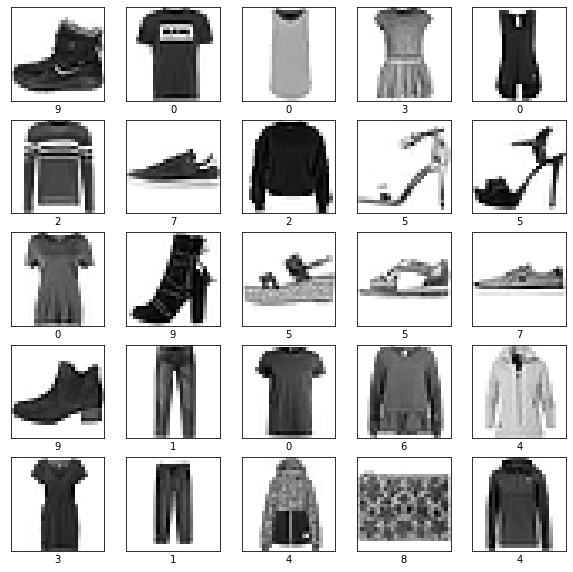

In [3]:
# Look at it
print(y_train[:10]) # Categorical data
print(X_train.shape)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

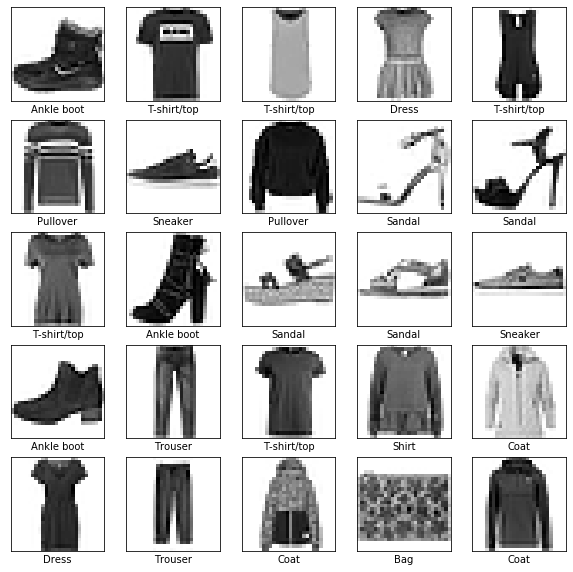

In [4]:
# Label the y data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

(60000, 28, 28)
(10000, 28, 28)


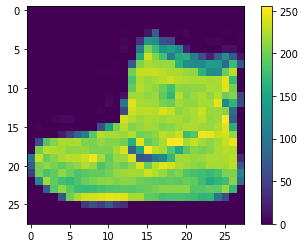

In [5]:
# Inspect shape of the feature data, as well as ranges:
print(X_train.shape)
print(X_test.shape)

# Look at ranges
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()


In [6]:
# Pre-processing

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train_df = pd.DataFrame(X_train)
print("Maximum value of X values: ", max(X_train_df.max()))

# normalize based on max value
# catch re-running exception where it's already normalized:
if max(X_train_df.max()) == 255.0:
    print("normalizing")
    X_train /= 255
    X_test /= 255
    
# Convert y to categorical outputs with one-hot encoding:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(y_train[0])

Maximum value of X values:  255.0
normalizing
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [12]:
# Set a baseline (source: https://github.com/correll/deep-learning/blob/master/lecture/Lab%202%20A%20first%20Network%20in%20Keras.ipynb)
model = Sequential()
model.add(Dense(10, input_shape=(784,)))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['categorical_accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train and set baseline!
print(X_train.shape)
print(y_train[0])
history = model.fit(X_train, y_train, batch_size=48000, epochs=200, verbose=1, validation_split=0.2)

(60000, 784)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 0s 10us/step - loss: 2.4272 - categorical_accuracy: 0.0683 - val_loss: 2.3646 - val_categorical_accuracy: 0.0916
Epoch 2/200
48000/48000 [==============================] - 0s 7us/step - loss: 2.3635 - categorical_accuracy: 0.0909 - val_loss: 2.3115 - val_categorical_accuracy: 0.1177
Epoch 3/200
48000/48000 [==============================] - 0s 6us/step - loss: 2.3117 - categorical_accuracy: 0.1158 - val_loss: 2.2668 - val_categorical_accuracy: 0.1417
Epoch 4/200
48000/48000 [==============================] - 0s 6us/step - loss: 2.2679 - categorical_accuracy: 0.1416 - val_loss: 2.2282 - val_categorical_accuracy: 0.1687
Epoch 5/200
48000/48000 [==============================] - 0s 6us/step - loss: 2.2301 - categorical_accuracy: 0.1678 - val_loss: 2.1941 - val_categorical_accuracy: 0.1963
Epoch 6/200
48000/48000 [========================

Epoch 49/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.6103 - categorical_accuracy: 0.5771 - val_loss: 1.5964 - val_categorical_accuracy: 0.5855
Epoch 50/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.6025 - categorical_accuracy: 0.5801 - val_loss: 1.5887 - val_categorical_accuracy: 0.5882
Epoch 51/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.5948 - categorical_accuracy: 0.5821 - val_loss: 1.5810 - val_categorical_accuracy: 0.5903
Epoch 52/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.5872 - categorical_accuracy: 0.5848 - val_loss: 1.5735 - val_categorical_accuracy: 0.5930
Epoch 53/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.5797 - categorical_accuracy: 0.5869 - val_loss: 1.5661 - val_categorical_accuracy: 0.5955
Epoch 54/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.5723 - categorical_accuracy: 0.5890 - val_loss: 1.5588 - v

Epoch 97/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.3378 - categorical_accuracy: 0.6365 - val_loss: 1.3258 - val_categorical_accuracy: 0.6460
Epoch 98/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.3337 - categorical_accuracy: 0.6372 - val_loss: 1.3218 - val_categorical_accuracy: 0.6465
Epoch 99/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.3298 - categorical_accuracy: 0.6379 - val_loss: 1.3179 - val_categorical_accuracy: 0.6473
Epoch 100/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.3258 - categorical_accuracy: 0.6386 - val_loss: 1.3139 - val_categorical_accuracy: 0.6476
Epoch 101/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.3219 - categorical_accuracy: 0.6392 - val_loss: 1.3101 - val_categorical_accuracy: 0.6483
Epoch 102/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.3181 - categorical_accuracy: 0.6396 - val_loss: 1.3062 

Epoch 145/200
48000/48000 [==============================] - 0s 5us/step - loss: 1.1864 - categorical_accuracy: 0.6574 - val_loss: 1.1750 - val_categorical_accuracy: 0.6653
Epoch 146/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.1840 - categorical_accuracy: 0.6575 - val_loss: 1.1726 - val_categorical_accuracy: 0.6658
Epoch 147/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.1816 - categorical_accuracy: 0.6578 - val_loss: 1.1702 - val_categorical_accuracy: 0.6660
Epoch 148/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.1792 - categorical_accuracy: 0.6581 - val_loss: 1.1678 - val_categorical_accuracy: 0.6662
Epoch 149/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.1768 - categorical_accuracy: 0.6584 - val_loss: 1.1654 - val_categorical_accuracy: 0.6665
Epoch 150/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.1745 - categorical_accuracy: 0.6586 - val_loss: 1.16

Epoch 193/200
48000/48000 [==============================] - 0s 5us/step - loss: 1.0901 - categorical_accuracy: 0.6691 - val_loss: 1.0790 - val_categorical_accuracy: 0.6755
Epoch 194/200
48000/48000 [==============================] - 0s 5us/step - loss: 1.0885 - categorical_accuracy: 0.6695 - val_loss: 1.0773 - val_categorical_accuracy: 0.6755
Epoch 195/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.0868 - categorical_accuracy: 0.6697 - val_loss: 1.0757 - val_categorical_accuracy: 0.6757
Epoch 196/200
48000/48000 [==============================] - 0s 4us/step - loss: 1.0852 - categorical_accuracy: 0.6699 - val_loss: 1.0741 - val_categorical_accuracy: 0.6763
Epoch 197/200
48000/48000 [==============================] - 0s 5us/step - loss: 1.0836 - categorical_accuracy: 0.6701 - val_loss: 1.0725 - val_categorical_accuracy: 0.6764
Epoch 198/200
48000/48000 [==============================] - 0s 5us/step - loss: 1.0820 - categorical_accuracy: 0.6703 - val_loss: 1.07

In [138]:
# Baseline
score = model.evaluate(X_test, y_test, verbose=1)
print("Baseline test score:", score[0])
print('Baseline test accuracy:', score[1])

10000/10000 [==============================] - 0s 23us/step
Baseline test score: 1.093458674812317
Baseline test accuracy: 0.6632000207901001


In [139]:
# Baseline 2 (ideas from: https://www.kaggle.com/arunkumarramanan/awesome-cv-with-fashion-mnist-classification)

print(X_train.shape)

model = Sequential()
model.add(Dense(128, input_shape=(784,), activation=tf.nn.relu))
model.add(Dense(10, activation=tf.nn.softmax))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=SGD(, metrics=['categorical_accuracy'])

history_2 = model.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.2)

(60000, 784)
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_82 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 85us/step - loss: 0.5180 - categorical_accuracy: 0.8171 - val_loss: 0.4487 - val_categorical_accuracy: 0.8402
Epoch 2/5
48000/48000 [==============================] - 4s 82us/step - loss: 0.3878 - categorical_accuracy: 0.8613 - val_loss: 0.3906 - val_categorical_accuracy: 0.8612
Epoch 3/5
48000/48000 [==============================] - 3s 70us/step - loss: 0.3455 - categorical_accurac

In [140]:
# Baseline 2
score_2 = model.evaluate(X_test, y_test, verbose=1)
print("Baseline test score:", score_2[0])
print('Baseline test accuracy:', score_2[1])

10000/10000 [==============================] - 0s 28us/step
Baseline test score: 0.3761920022964478
Baseline test accuracy: 0.8676000237464905


## Summary of progress so far:
An increase in ~20% test accuracy by decreasing the number of epochs, changing the the optimizer to 'adam', and adding a first Dense layer of 128! Huzzah! Let's keep going.

## Do some hyper parameter tuning using Grid Search

Parameters available:
- batch size
- epochs
- drop out
- optimizers

In [144]:
# Search for the optimal hyperparameters using grid search (Source: https://medium.com/@masonrchildress/how-to-gridsearch-over-a-keras-neural-network-with-a-pipeline-51fbfb62185e)

# create model function
def create_model(optimizer='adam', dropout=0.1):
    model = Sequential()
    model.add(Dense(128, input_shape=(784,), activation=("relu")))
    model.add(Dense(10, activation=("softmax")))
    model.add(Dropout(dropout))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    return model

# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_model, verbose=1)

# Set grid search parameters:
optimizers = ['rmsprop', 'adam', SGD()]
epochs = [5, 50, 100]
dropout = [0.1, 0.2]
    

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs,  dropout=dropout)


# Use it!
grid = GridSearchCV(estimator=neural_network, cv=3, param_grid=hyperparameters)

grid_search_fit = grid.fit(X_train, y_train)


Epoch 1/5
40000/40000 [==============================] - 3s 82us/step - loss: 2.0729 - accuracy: 0.7340
Epoch 2/5
40000/40000 [==============================] - 3s 76us/step - loss: 1.9535 - accuracy: 0.7780
Epoch 3/5
40000/40000 [==============================] - 4s 103us/step - loss: 1.9090 - accuracy: 0.7894
Epoch 4/5
40000/40000 [==============================] - 3s 64us/step - loss: 1.8610 - accuracy: 0.7964 0s - loss:
Epoch 5/5
20000/20000 [==============================] - 1s 29us/step
Epoch 1/5
40000/40000 [==============================] - 3s 63us/step - loss: 2.0958 - accuracy: 0.7321
Epoch 2/5
40000/40000 [==============================] - 2s 58us/step - loss: 1.9038 - accuracy: 0.7778
Epoch 3/5
40000/40000 [==============================] - 5s 118us/step - loss: 1.9228 - accuracy: 0.7883
Epoch 4/5
40000/40000 [==============================] - 4s 105us/step - loss: 1.8883 - accuracy: 0.7953
Epoch 5/5
20000/20000 [==============================] - 1s 33us/step
Epoch 1/5
4000

40000/40000 [==============================] - 2s 57us/step - loss: 1.9429 - accuracy: 0.7941
Epoch 5/50
40000/40000 [==============================] - 2s 57us/step - loss: 1.8703 - accuracy: 0.8016
Epoch 6/50
40000/40000 [==============================] - 2s 56us/step - loss: 1.8227 - accuracy: 0.8084
Epoch 7/50
40000/40000 [==============================] - 2s 57us/step - loss: 1.8875 - accuracy: 0.8057
Epoch 8/50
40000/40000 [==============================] - 2s 56us/step - loss: 1.8651 - accuracy: 0.8101
Epoch 9/50
40000/40000 [==============================] - 2s 55us/step - loss: nan - accuracy: 0.1677
Epoch 10/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 11/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 12/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 13/50
40000/40000 [==============================] - 2s 56us/step - l

40000/40000 [==============================] - 3s 65us/step - loss: 1.8198 - accuracy: 0.8119
Epoch 8/50
40000/40000 [==============================] - 3s 63us/step - loss: 1.7995 - accuracy: 0.8177
Epoch 9/50
40000/40000 [==============================] - 3s 64us/step - loss: 1.8440 - accuracy: 0.8157
Epoch 10/50
40000/40000 [==============================] - 3s 65us/step - loss: 1.8117 - accuracy: 0.8224
Epoch 11/50
40000/40000 [==============================] - 3s 64us/step - loss: 1.8563 - accuracy: 0.8211
Epoch 12/50
40000/40000 [==============================] - 3s 77us/step - loss: 1.8194 - accuracy: 0.8258
Epoch 13/50
40000/40000 [==============================] - 3s 74us/step - loss: 1.8058 - accuracy: 0.8275
Epoch 14/50
40000/40000 [==============================] - 3s 64us/step - loss: 1.7627 - accuracy: 0.8318
Epoch 15/50
40000/40000 [==============================] - 3s 74us/step - loss: 1.8132 - accuracy: 0.8299
Epoch 16/50
40000/40000 [==============================] - 3

40000/40000 [==============================] - 2s 53us/step - loss: 1.9646 - accuracy: 0.7691
Epoch 6/50
40000/40000 [==============================] - 2s 52us/step - loss: 2.0036 - accuracy: 0.7703
Epoch 7/50
40000/40000 [==============================] - 2s 49us/step - loss: 1.9384 - accuracy: 0.7770
Epoch 8/50
40000/40000 [==============================] - 2s 49us/step - loss: 1.9818 - accuracy: 0.7776
Epoch 9/50
40000/40000 [==============================] - 2s 47us/step - loss: 2.0071 - accuracy: 0.7788
Epoch 10/50
40000/40000 [==============================] - 2s 52us/step - loss: 1.9548 - accuracy: 0.7820
Epoch 11/50
40000/40000 [==============================] - 2s 49us/step - loss: 1.9269 - accuracy: 0.7861 0s - loss: 1.933
Epoch 12/50
40000/40000 [==============================] - 2s 58us/step - loss: 1.9221 - accuracy: 0.7875 0s
Epoch 13/50
40000/40000 [==============================] - 2s 50us/step - loss: 1.9604 - accuracy: 0.7868
Epoch 14/50
40000/40000 [=================

40000/40000 [==============================] - 2s 60us/step - loss: 1.8618 - accuracy: 0.8066
Epoch 8/100
40000/40000 [==============================] - 3s 64us/step - loss: 1.8817 - accuracy: 0.8101
Epoch 9/100
40000/40000 [==============================] - 2s 58us/step - loss: 1.8172 - accuracy: 0.8155
Epoch 10/100
40000/40000 [==============================] - 2s 57us/step - loss: 1.8876 - accuracy: 0.8125
Epoch 11/100
40000/40000 [==============================] - 3s 67us/step - loss: 1.8395 - accuracy: 0.8169
Epoch 12/100
40000/40000 [==============================] - 3s 85us/step - loss: nan - accuracy: 0.2328
Epoch 13/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.0988
Epoch 14/100
40000/40000 [==============================] - 2s 59us/step - loss: nan - accuracy: 0.0988: 0s - loss: nan - acc
Epoch 15/100
40000/40000 [==============================] - 2s 58us/step - loss: nan - accuracy: 0.0988
Epoch 16/100
40000/40000 [================

40000/40000 [==============================] - 3s 72us/step - loss: nan - accuracy: 0.0995: 0s - loss
Epoch 61/100
40000/40000 [==============================] - 3s 72us/step - loss: nan - accuracy: 0.0995
Epoch 62/100
40000/40000 [==============================] - 3s 73us/step - loss: nan - accuracy: 0.0995
Epoch 63/100
40000/40000 [==============================] - 2s 62us/step - loss: nan - accuracy: 0.0995
Epoch 64/100
40000/40000 [==============================] - 3s 86us/step - loss: nan - accuracy: 0.0995
Epoch 65/100
40000/40000 [==============================] - 3s 70us/step - loss: nan - accuracy: 0.0995: 1s - loss: nan - accura - ETA: 1s - loss: nan - accuracy - ETA: 0s - loss: nan - accuracy:  - ETA: 0s - loss: nan - accuracy: 0
Epoch 66/100
40000/40000 [==============================] - 2s 58us/step - loss: nan - accuracy: 0.0995
Epoch 67/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0995
Epoch 68/100
40000/40000 [===============

40000/40000 [==============================] - 3s 66us/step - loss: 1.8607 - accuracy: 0.8042
Epoch 7/100
40000/40000 [==============================] - 3s 63us/step - loss: 1.8659 - accuracy: 0.8087 0s - loss: 1.8
Epoch 8/100
40000/40000 [==============================] - 3s 64us/step - loss: 1.8515 - accuracy: 0.8109
Epoch 9/100
40000/40000 [==============================] - 3s 65us/step - loss: 1.8145 - accuracy: 0.8176
Epoch 10/100
40000/40000 [==============================] - 3s 65us/step - loss: 1.8124 - accuracy: 0.8181
Epoch 11/100
40000/40000 [==============================] - 3s 64us/step - loss: 1.8124 - accuracy: 0.8227
Epoch 12/100
40000/40000 [==============================] - 3s 66us/step - loss: 1.8455 - accuracy: 0.8205
Epoch 13/100
40000/40000 [==============================] - 3s 65us/step - loss: 1.7974 - accuracy: 0.8278 0s - loss: 1.7965 - accuracy: 0.82
Epoch 14/100
40000/40000 [==============================] - 3s 64us/step - loss: 1.7895 - accuracy: 0.8280
Epo

Epoch 51/100
40000/40000 [==============================] - 2s 62us/step - loss: nan - accuracy: 0.0995
Epoch 52/100
40000/40000 [==============================] - 2s 62us/step - loss: nan - accuracy: 0.0995: 1s - loss:
Epoch 53/100
40000/40000 [==============================] - 3s 64us/step - loss: nan - accuracy: 0.0995
Epoch 54/100
40000/40000 [==============================] - 3s 79us/step - loss: nan - accuracy: 0.0995: 0s - loss: nan - accuracy: 0.099
Epoch 55/100
40000/40000 [==============================] - 4s 97us/step - loss: nan - accuracy: 0.0995
Epoch 56/100
40000/40000 [==============================] - 3s 81us/step - loss: nan - accuracy: 0.0995
Epoch 57/100
40000/40000 [==============================] - 4s 92us/step - loss: nan - accuracy: 0.0995
Epoch 58/100
40000/40000 [==============================] - 3s 83us/step - loss: nan - accuracy: 0.0995
Epoch 59/100
40000/40000 [==============================] - 3s 70us/step - loss: nan - accuracy: 0.0995
Epoch 60/100
40000

40000/40000 [==============================] - 4s 92us/step - loss: 1.7460 - accuracy: 0.8405
Epoch 99/100
40000/40000 [==============================] - 3s 77us/step - loss: 1.7647 - accuracy: 0.8398
Epoch 100/100
20000/20000 [==============================] - 1s 58us/step
Epoch 1/100
40000/40000 [==============================] - 2s 59us/step - loss: 2.3123 - accuracy: 0.6731
Epoch 2/100
40000/40000 [==============================] - 2s 58us/step - loss: 2.0554 - accuracy: 0.7400
Epoch 3/100
40000/40000 [==============================] - 2s 56us/step - loss: 2.0195 - accuracy: 0.7537
Epoch 4/100
40000/40000 [==============================] - 2s 54us/step - loss: 2.0210 - accuracy: 0.7599
Epoch 5/100
40000/40000 [==============================] - 2s 60us/step - loss: 2.0018 - accuracy: 0.7651
Epoch 6/100
40000/40000 [==============================] - 2s 59us/step - loss: 1.9757 - accuracy: 0.7681
Epoch 7/100
40000/40000 [==============================] - 2s 56us/step - loss: 1.9796 - 

40000/40000 [==============================] - 3s 86us/step - loss: 1.8070 - accuracy: 0.8280
Epoch 73/100
40000/40000 [==============================] - 3s 87us/step - loss: 1.8107 - accuracy: 0.8277
Epoch 74/100
40000/40000 [==============================] - 4s 89us/step - loss: 1.8439 - accuracy: 0.8260
Epoch 75/100
40000/40000 [==============================] - 4s 97us/step - loss: 1.8317 - accuracy: 0.8287
Epoch 76/100
40000/40000 [==============================] - 4s 102us/step - loss: 1.8411 - accuracy: 0.8275
Epoch 77/100
40000/40000 [==============================] - 3s 80us/step - loss: 1.8082 - accuracy: 0.8297 0s - loss: 1.8003 - accu
Epoch 78/100
40000/40000 [==============================] - 3s 77us/step - loss: 1.7665 - accuracy: 0.8314
Epoch 79/100
40000/40000 [==============================] - 4s 96us/step - loss: 1.8371 - accuracy: 0.8282
Epoch 80/100
40000/40000 [==============================] - 3s 84us/step - loss: 1.8227 - accuracy: 0.8295
Epoch 81/100
40000/40000

20000/20000 [==============================] - 1s 39us/step
Epoch 1/5
40000/40000 [==============================] - 4s 106us/step - loss: 3.6203 - accuracy: 0.66000s - loss: 3.6202 - accuracy: 0.66
Epoch 2/5
40000/40000 [==============================] - 4s 101us/step - loss: 3.5154 - accuracy: 0.6947
Epoch 3/5
40000/40000 [==============================] - 4s 93us/step - loss: 3.4586 - accuracy: 0.7079
Epoch 4/5
40000/40000 [==============================] - 4s 104us/step - loss: 3.4161 - accuracy: 0.7136
Epoch 5/5
20000/20000 [==============================] - 1s 40us/step
Epoch 1/5
40000/40000 [==============================] - 4s 109us/step - loss: 3.6788 - accuracy: 0.6599
Epoch 2/5
40000/40000 [==============================] - 4s 94us/step - loss: 3.5239 - accuracy: 0.6966
Epoch 3/5
40000/40000 [==============================] - 4s 93us/step - loss: 3.4768 - accuracy: 0.7063
Epoch 4/5
40000/40000 [==============================] - 4s 90us/step - loss: 3.4677 - accuracy: 0.7107


40000/40000 [==============================] - 2s 58us/step - loss: nan - accuracy: 0.0995
Epoch 26/50
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0995
Epoch 27/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 28/50
40000/40000 [==============================] - 2s 58us/step - loss: nan - accuracy: 0.0995
Epoch 29/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 30/50
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0995
Epoch 31/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 32/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 33/50
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 34/50
40000/40000 [==============================] - 2s 57us/step - loss: nan -

40000/40000 [==============================] - 3s 63us/step - loss: 3.3493 - accuracy: 0.7534
Epoch 27/50
40000/40000 [==============================] - 2s 60us/step - loss: 3.3337 - accuracy: 0.7554
Epoch 28/50
40000/40000 [==============================] - 2s 61us/step - loss: 3.3994 - accuracy: 0.7518
Epoch 29/50
40000/40000 [==============================] - 2s 60us/step - loss: 3.3989 - accuracy: 0.7527
Epoch 30/50
40000/40000 [==============================] - 2s 59us/step - loss: 3.3832 - accuracy: 0.7538
Epoch 31/50
40000/40000 [==============================] - 2s 60us/step - loss: 3.3430 - accuracy: 0.7563
Epoch 32/50
40000/40000 [==============================] - 2s 60us/step - loss: 3.2841 - accuracy: 0.7623
Epoch 33/50
40000/40000 [==============================] - 2s 60us/step - loss: 3.3333 - accuracy: 0.7570
Epoch 34/50
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1647
Epoch 35/50
40000/40000 [==============================] - 2s

40000/40000 [==============================] - 2s 50us/step - loss: 3.4553 - accuracy: 0.7169
Epoch 28/50
40000/40000 [==============================] - 2s 50us/step - loss: 3.4449 - accuracy: 0.7187
Epoch 29/50
40000/40000 [==============================] - 2s 50us/step - loss: 3.4551 - accuracy: 0.7203
Epoch 30/50
40000/40000 [==============================] - 2s 50us/step - loss: 3.4353 - accuracy: 0.7211
Epoch 31/50
40000/40000 [==============================] - 2s 50us/step - loss: 3.5086 - accuracy: 0.7169
Epoch 32/50
40000/40000 [==============================] - 2s 49us/step - loss: 3.4226 - accuracy: 0.7223
Epoch 33/50
40000/40000 [==============================] - 2s 49us/step - loss: 3.4450 - accuracy: 0.7232
Epoch 34/50
40000/40000 [==============================] - 2s 49us/step - loss: 3.4160 - accuracy: 0.7236
Epoch 35/50
40000/40000 [==============================] - 2s 50us/step - loss: 3.4246 - accuracy: 0.7255
Epoch 36/50
40000/40000 [==============================] -

40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0988
Epoch 30/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0988
Epoch 31/100
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0988
Epoch 32/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0988
Epoch 33/100
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0988
Epoch 34/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0988
Epoch 35/100
40000/40000 [==============================] - 2s 58us/step - loss: nan - accuracy: 0.0988
Epoch 36/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.0988
Epoch 37/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0988
Epoch 38/100
40000/40000 [==============================] - 2s 57us/step - lo

Epoch 6/100
40000/40000 [==============================] - 2s 57us/step - loss: 3.4263 - accuracy: 0.7209
Epoch 7/100
40000/40000 [==============================] - 2s 57us/step - loss: 3.4524 - accuracy: 0.7225
Epoch 8/100
40000/40000 [==============================] - 2s 57us/step - loss: 3.4800 - accuracy: 0.7210
Epoch 9/100
40000/40000 [==============================] - 2s 57us/step - loss: 3.3874 - accuracy: 0.7291
Epoch 10/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.2706
Epoch 11/100
40000/40000 [==============================] - 2s 56us/step - loss: nan - accuracy: 0.0995
Epoch 12/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0995
Epoch 13/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0995
Epoch 14/100
40000/40000 [==============================] - 2s 57us/step - loss: nan - accuracy: 0.0995
Epoch 15/100
40000/40000 [==============================

40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1016
Epoch 59/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1016
Epoch 60/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1016
Epoch 61/100
40000/40000 [==============================] - 2s 61us/step - loss: nan - accuracy: 0.1016: 1s - loss: nan - accu - ETA: 0s - loss: nan
Epoch 62/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1016
Epoch 63/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1016
Epoch 64/100
40000/40000 [==============================] - 2s 59us/step - loss: nan - accuracy: 0.1016
Epoch 65/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1016
Epoch 66/100
40000/40000 [==============================] - 2s 60us/step - loss: nan - accuracy: 0.1016
Epoch 67/100
40000/40000 [======

40000/40000 [==============================] - 2s 61us/step - loss: 3.3984 - accuracy: 0.7330
Epoch 12/100
40000/40000 [==============================] - 2s 60us/step - loss: 3.3638 - accuracy: 0.7376
Epoch 13/100
40000/40000 [==============================] - 2s 61us/step - loss: 3.4156 - accuracy: 0.7365
Epoch 14/100
40000/40000 [==============================] - 2s 60us/step - loss: 3.2869 - accuracy: 0.7462
Epoch 15/100
40000/40000 [==============================] - 2s 60us/step - loss: 3.4189 - accuracy: 0.7373
Epoch 16/100
40000/40000 [==============================] - 2s 60us/step - loss: 3.3488 - accuracy: 0.7436
Epoch 17/100
40000/40000 [==============================] - 2s 60us/step - loss: 3.3655 - accuracy: 0.7447
Epoch 18/100
40000/40000 [==============================] - 2s 60us/step - loss: 3.3818 - accuracy: 0.7461
Epoch 19/100
40000/40000 [==============================] - 2s 61us/step - loss: 3.3639 - accuracy: 0.7460 0s - los
Epoch 20/100
40000/40000 [===============

40000/40000 [==============================] - 2s 49us/step - loss: nan - accuracy: 0.1016
Epoch 65/100
40000/40000 [==============================] - 2s 49us/step - loss: nan - accuracy: 0.1016
Epoch 66/100
40000/40000 [==============================] - 2s 52us/step - loss: nan - accuracy: 0.1016
Epoch 67/100
40000/40000 [==============================] - 2s 59us/step - loss: nan - accuracy: 0.1016: 1s - loss: nan 
Epoch 68/100
40000/40000 [==============================] - 2s 48us/step - loss: nan - accuracy: 0.1016
Epoch 69/100
40000/40000 [==============================] - 2s 49us/step - loss: nan - accuracy: 0.1016
Epoch 70/100
40000/40000 [==============================] - 2s 49us/step - loss: nan - accuracy: 0.1016
Epoch 71/100
40000/40000 [==============================] - 2s 49us/step - loss: nan - accuracy: 0.1016: 0s - loss: nan - a
Epoch 72/100
40000/40000 [==============================] - 2s 49us/step - loss: nan - accuracy: 0.1016: 0s - loss: nan - accurac
Epoch 73/100
4

40000/40000 [==============================] - 2s 48us/step - loss: 3.5409 - accuracy: 0.7035
Epoch 15/100
40000/40000 [==============================] - 2s 48us/step - loss: 3.4930 - accuracy: 0.7058
Epoch 16/100
40000/40000 [==============================] - 2s 48us/step - loss: 3.5047 - accuracy: 0.7072
Epoch 17/100
40000/40000 [==============================] - 2s 48us/step - loss: 3.4882 - accuracy: 0.7095 0s - loss: 3.468
Epoch 18/100
40000/40000 [==============================] - 2s 49us/step - loss: 3.4478 - accuracy: 0.7108 0s - loss: 3.4537 - accuracy: 0.
Epoch 19/100
40000/40000 [==============================] - 2s 48us/step - loss: 3.4291 - accuracy: 0.7139
Epoch 20/100
40000/40000 [==============================] - 2s 48us/step - loss: 3.4224 - accuracy: 0.7156
Epoch 21/100
40000/40000 [==============================] - 2s 51us/step - loss: 3.5078 - accuracy: 0.7112
Epoch 22/100
40000/40000 [==============================] - 3s 75us/step - loss: 3.4914 - accuracy: 0.7111


60000/60000 [==============================] - 3s 48us/step - loss: 1.7750 - accuracy: 0.8321
Epoch 64/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.7894 - accuracy: 0.8313
Epoch 65/100
60000/60000 [==============================] - 3s 49us/step - loss: 1.8111 - accuracy: 0.8306
Epoch 66/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.8234 - accuracy: 0.8306
Epoch 67/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.8158 - accuracy: 0.8323
Epoch 68/100
60000/60000 [==============================] - 3s 49us/step - loss: 1.7834 - accuracy: 0.8328
Epoch 69/100
60000/60000 [==============================] - 3s 49us/step - loss: 1.7868 - accuracy: 0.8335
Epoch 70/100
60000/60000 [==============================] - 3s 49us/step - loss: 1.7972 - accuracy: 0.8335
Epoch 71/100
60000/60000 [==============================] - 3s 49us/step - loss: 1.8132 - accuracy: 0.8327
Epoch 72/100
60000/60000 [========================

In [162]:
# View the best parameters:
print("Best parameters ", grid_search_fit.best_params_)

print("Best accuracy score: ", grid_search_fit.best_score_)

# Predict test data:
y_pred = grid_search_fit.best_estimator_.predict(X_test)
y_pred = np_utils.to_categorical(y_pred, 10)

# Report results from test data:

def report_results(model, X, y, pred):        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average=None)
    prec = precision_score(y, pred, average=None)
    rec = recall_score(y, pred, average=None)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_search_fit.best_estimator_, X_test, y_test, y_pred)


Best parameters  {'dropout': 0.1, 'epochs': 100, 'optimizer': <keras.optimizers.SGD object at 0x1bfae3dd8>}
Best accuracy score:  0.8856666684150696
10000/10000 [==============================] - 0s 31us/step


{'f1': array([0.83949416, 0.97637004, 0.77330392, 0.88726919, 0.80072793,
        0.96226415, 0.6966649 , 0.95081967, 0.96430367, 0.96113074]),
 'acc': 0.8823,
 'precision': array([0.81723485, 0.9817998 , 0.86223862, 0.86294896, 0.7345576 ,
        0.9556213 , 0.74015748, 0.94471866, 0.96966633, 0.97043833]),
 'recall': array([0.863, 0.971, 0.701, 0.913, 0.88 , 0.969, 0.658, 0.957, 0.959,
        0.952])}

In [17]:
# Try the best model from class, but using grid search again to confirm the hyperparameters
# since this is a slightly different dataset and using dropout
# From "Deeplearning with Keras"

NB_CLASSES = 10 

model = Sequential()
# CONV => RELU => POOL
model.add(Dense(500, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dropout(0.1))
# a softmax classifier
model.add(Dense(NB_CLASSES))
model.add(Activation("softmax"))
# dropout
model.add(Dropout(0.1))
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])


history = model.fit(X_train, y_train,batch_size=128, epochs=30,verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)[1]
score


Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 3s 56us/step - loss: 2.0749 - accuracy: 0.7406 - val_loss: 0.4502 - val_accuracy: 0.8374
Epoch 2/30
48000/48000 [==============================] - 2s 51us/step - loss: 1.9543 - accuracy: 0.7783 - val_loss: 0.3876 - val_accuracy: 0.8591
Epoch 3/30
48000/48000 [==============================] - 2s 52us/step - loss: 1.8894 - accuracy: 0.7925 - val_loss: 0.3681 - val_accuracy: 0.8643
Epoch 4/30
48000/48000 [==============================] - 2s 50us/step - loss: 1.8750 - accuracy: 0.7991 - val_loss: 0.3550 - val_accuracy: 0.8717
Epoch 5/30
48000/48000 [==============================] - 2s 52us/step - loss: 1.8371 - accuracy: 0.8063 - val_loss: 0.3317 - val_accuracy: 0.8785
Epoch 6/30
48000/48000 [==============================] - 2s 52us/step - loss: 1.9057 - accuracy: 0.8069 - val_loss: 0.3255 - val_accuracy: 0.8817
Epoch 7/30
48000/48000 [==============================] - 2s 52us/st

0.8830999732017517

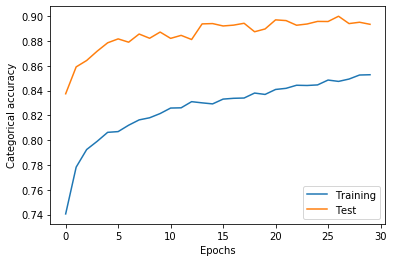

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

## Visualize it!

Test accuracy: 0.8830999732017517
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


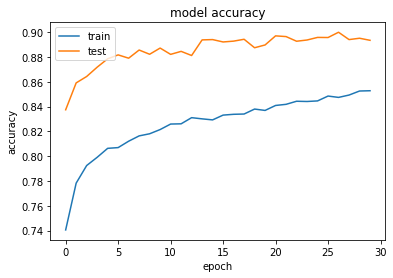

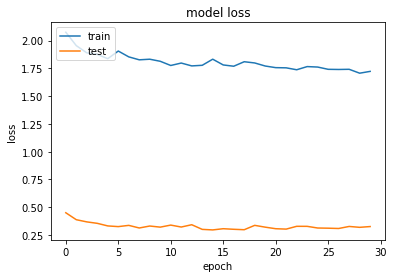

In [50]:

print('Test accuracy:', score)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()